# Data Fundamentals (H)
John H. Williamson -- Session 2018/2019

----
<font color="red"> Read the submission instructions at the bottom of this notebook **carefully** before submitting </font> 

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

Note that marks shown when tests pass are **provisional** and could change after grading.

In [3]:
NAME = "Stuart Reilly" ## fill these in 
STUDENT_ID = "2258082"  ## e.g. 2222222

---

## Lab 8: Assessed
# Introduction to probability


### Notes
It is recommended to keep the lecture notes open while doing this lab exercise.

**This exercise is assessed**. Make sure you upload your solution by the deadline. See the notes at the bottom of this notebook for submission guidance. The exercise is marked out of 40.

Unlike other DF(H) labs, the material in this lab is **examinable**. You should understand this material fully. Full solutions will be posted for study if you do not manage to complete the lab.

You will need to know the following logarithm identities in this lab:
* $\log(a)+\log(b) = \log(ab)$ 
* $\log(a)-\log(b) = \log(a/b),\  b\neq 0$

$$\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\vec{x}\real
$$

In [4]:
# Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
import numpy as np  # NumPy
import scipy.stats 

from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
print("Everything imported OK")
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
np.random.seed(1000)

Everything imported OK


## Purpose of this lab
After doing this lab you should know:

* what  Markov chains are
* how Markov chains can be used to model sequences
* how Markov chains can be learned, simulated and tested against data


# Tutorial: discrete random variables
This tutorial (re)introduces the ideas of 
* simulation by sampling; 
* estimation using the empirical distribution; 
* and likelihood and likelihood ratios.

### Discrete simulation
**Simulation** of a random occurrence can be achieved by sampling from a distribution. For example, sampling a number of *biased* coin tosses can be achieved by drawing a random number uniformly in the range (0.0 ,1.0) and then *thresholding* at a specific cutoff to assign one portion to "heads" (0) and one portion to "tails" (1). For example, we might generate 100 values randomly from 0-1


In [5]:
uniform_numbers = np.random.uniform(0,1,100)
print(uniform_numbers)

[0.65358959 0.11500694 0.95028286 0.4821914  0.87247454 0.21233268
 0.04070962 0.39719446 0.2331322  0.84174072 0.20708234 0.74246953
 0.39215413 0.18225652 0.74353941 0.06958208 0.8853372  0.9526444
 0.93114343 0.41543095 0.02898166 0.98202748 0.33963768 0.70668719
 0.36187707 0.0351059  0.85505825 0.65725351 0.76568299 0.55408724
 0.88509294 0.90419762 0.0104217  0.07455674 0.24462921 0.13330475
 0.6979251  0.39820488 0.88312219 0.18100751 0.43249917 0.0181432
 0.69143786 0.46969065 0.12822219 0.89133705 0.91820362 0.07312099
 0.04544794 0.4385729  0.60172093 0.31022703 0.68190824 0.20901315
 0.5196043  0.56598883 0.44116739 0.13755616 0.21354319 0.13337189
 0.3222967  0.23388712 0.52749816 0.56597116 0.43822528 0.32187262
 0.55964081 0.86534558 0.84728288 0.10781717 0.31631948 0.40947866
 0.68708901 0.70223529 0.44619794 0.42032208 0.80263059 0.53861757
 0.92350049 0.06190754 0.36758345 0.97039877 0.69910395 0.89097558
 0.25355272 0.72552711 0.20349443 0.53751182 0.236943   0.436492

We could then define a threshold. If we set this to 0.5, roughly half of the values should be below and half above. This is an unbiased coin flip.  If we set the threshold to 0.1, roughly 10% of values will be below the threshold and 90% will be above. This is *biased* towards one output.

In [6]:
print(np.sum(uniform_numbers>0.5)) # how many samples greater than 0.5?

47


In [7]:
print(np.sum(uniform_numbers>0.1)) # how many greater than 0.1?

89


We can use this to write a function to sample a "biased" coin, returning an array of `0` or `1` for `heads` or `tails`:

In [8]:
# 10 numbers, in range [0,1]
def toss_coin(n, bias=0.5):
    coin_tosses = np.random.uniform(0,1, (n))
    return np.where(coin_tosses<bias, 0, 1)

In [9]:
    
# fair toss: bias = 0.5
print("Fair       \t\t", toss_coin(32, bias=0.5))

# biased to 0s: bias = 0.85
print("Biased towards 0\t", toss_coin(32, bias=0.85))

# biased to 1s: bias = 0.1
print("Biased towards 1\t", toss_coin(32, bias=0.1))

Fair       		 [0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0]
Biased towards 0	 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1]
Biased towards 1	 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Discrete estimation
**Estimation** of the distribution of a discrete random variable can be computed using the **empirical distribution**. This is just the count of the number of specific outcomes seen divided by the total number of trials. If we have a biased coin, we can estimate how biased it is by computing the empirical probability mass function:

$$P(X=0) = \frac{N_0} {N_0+N_1},\quad P(X=1) = \frac{N_1} {N_0+N_1},$$

where $P(X=0)$ is the probability of getting a 0, $N_0$ is the number of zeros seen, and $N= N_0+N_1$ is the number of tosses performed. The same argument applies for $P(X=1)$.
This estimate will be better as $N$ increases.


In [10]:
bias = 0.9 # you can try adjusting this to confirm there 
#  is nothing special here

for n in (5,10,50,500,1000, 5000, 10000, 50000):
    tosses = toss_coin(n, bias)
    # NB: np.sum(tosses) is a count of the number
    # of 1s seen, if the values are only 0 or 1
    n1 = np.sum(tosses)
    est_bias = n1 / n  
    print("N=%6d\tN_1=%4d\test. bias:%.4f\ttrue bias:%.4f" % ( n, n1, 1.0-est_bias, bias))

N=     5	N_1=   1	est. bias:0.8000	true bias:0.9000
N=    10	N_1=   3	est. bias:0.7000	true bias:0.9000
N=    50	N_1=   4	est. bias:0.9200	true bias:0.9000
N=   500	N_1=  53	est. bias:0.8940	true bias:0.9000
N=  1000	N_1= 111	est. bias:0.8890	true bias:0.9000
N=  5000	N_1= 500	est. bias:0.9000	true bias:0.9000
N= 10000	N_1= 994	est. bias:0.9006	true bias:0.9000
N= 50000	N_1=5115	est. bias:0.8977	true bias:0.9000


### Likelihood testing
We can also compute how likely a collection of observations $x_1, x_2, \dots$ was to have been generated from a specific distribution if we know the **likelihood function** for that distribution.

The likelihood of a collection of values, *assuming they are independent*, is just the product of the likelihood of each value:

$$\mathcal{L}(x_1, x_2, \dots, x_n) = \mathcal{L}(x_1)\mathcal{L}(x_2)\dots\mathcal{L}(x_n) = \prod_{i=1}^n f_X(x_i),$$

where $f_X(x)$ is the PMF or PDF that describes the distribution; the likelihood function for a specific observation. 

We can write $\mathcal{L}(\theta|x)$ to explicitly include the parameters $\theta$ of the distribution; for example the bias of the coin is the only parameter in the coin tossing example. This should be read as the the likelihood of the parameter $\theta$ given the data $x$.

Be careful: when working out likelihoods we *postulate* a process that might be generating data, and see how closely the observations we see "look like" they came from that process. We can use this to compare the likelihood of two sequences having been generated by a **known, hypothesised distribution that might have been generating them**.

In [11]:
# toss a coin 10 times
fair_coins = toss_coin(10, 0.5)

In [12]:
# compute likelihood of seeing a head or a tail
# given a specific bias
def lik_coin(coin, bias):
    if coin==0:
        return bias
    else:
        return (1-bias)

In [13]:
# compute likelihood of the entire sequence
def likelihood(lik_fn, observations):
    lik = 1.0
    for obs in observations:
        lik = lik * lik_fn(obs)
    return lik

In [14]:
# compute likelihood under the assumption
# that we have a fair coin toss
# (what actually generated this sequence)
l_fair = likelihood(lambda x: lik_coin(x, 0.5), fair_coins)

# compute likelihood for unfair coin toss
# with 90% bias towards choosing a 0 (head)
l_bias_0 = likelihood(lambda x: lik_coin(x, 0.9), fair_coins)

print("Likelihood from fair coin model", l_fair)
print("Likelihood under a biased coin model", l_bias_0)

Likelihood from fair coin model 0.0009765625
Likelihood under a biased coin model 5.314409999999997e-05


### Likelihood ratios
We can compare to likelihood using the **likelihood ratio**. This gives us a measure
of how (relatively) likely a set of observations was to have been generated by one postulated model than another.

In [15]:
# compute ratio of likelihoods
print(fair_coins)
bias_ratio = (l_fair/l_bias_0)
print("""This sequence is
{t} times more likely to have been generated 
by a fair coin toss than a 90% biased coin toss""".format(t=bias_ratio))

[0 1 0 1 1 0 1 0 0 0]
This sequence is
18.375746319911347 times more likely to have been generated 
by a fair coin toss than a 90% biased coin toss


## Important notes
In real applications, we would have to work with the **logarithm** of the **likelihood** (**log-likelihood**) instead of likelihoods, to avoid numerical underflow.

# Assessed portion: Markov processes
A **stochastic process** or a **random process** is a process that evolves over *time* in an (partially) unpredictable way. The altitude of an aircraft might be modelled as a stochastic process. Although the altitude is controlled to keep it relatively steady during level flight, fluctuations due to turbulence shift the altitude randomly. This randomness can vary; in smooth air the process might be very stable and predictable, but become increasingly random in rough, turbulent air. The position of the aircraft in one moment depends on where it was a moment before, but with some element of randomness.

Unlike the coin tosses, where each toss was *independent* of the one before, **stochastic processes** capture dependence over time.


<img src="imgs/turbulence.png">

*[Original Image by Sergey Kustov [from Wikimedia Commons](https://commons.wikimedia.org/wiki/Category:Featured_pictures_of_aircraft#/media/File:Aeroflot_Airbus_A330_Kustov.jpg) CC-BY-SA 3.0]*

## Markov process
A **Markov process** is a particularly simple kind of **stochastic process**. A **Markov process** is any stochastic process that preserves the **Markov property**:

### Markov property

>The distribution of the state at time $t$ depends **only** on the state at the previous time $t-1$. No other history influences the behaviour of the system. 

Sequential samples from a Markov process are **not** independent; each sample depends on the prior sample (and *only* on the prior sample).  These models are tractable to do computations with, and we can often approximate a stochastic process which might have long-term dependencies with a Markov process with a single step dependency.

### Evolution over time

We consider the process to evolve one time step after the other, so we have a state at time $t=0, t=1, \dots$, represented by a random variable $X_t$, which takes on values $x_1, x_2, x_3, \dots$ at each time step.

The evolution of Markov process is described by a single conditional probability distribution, $P(\vec{X}_t=x_t|x_{t-1})$, the **transition distribution**. It defines what values could occur in one time step, depending on those on the previous time step. Markov processes can have **discrete states** (i.e. their state transitions involve discrete random variables) or **continuous states** (continuous random variables). We will only deal with discrete time, discrete state Markov processes: Markov chains in DF(H).

## Discrete time, discrete state: Markov chains

 
### Gilbert model for flickering lights
Consider the problem of modeling the gentle flickering of an LED candle:

<img src="imgs/candle.jpg"> <br><br>*[[Image](https://flickr.com/photos/syntheticaperture/2667040501 "0806B06 - LED Candle Experiment") by [syntheticaperture](https://flickr.com/people/syntheticaperture) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)]*

*[This problem is inspired by the [analysis on cpldcpu's blog](https://cpldcpu.com/2013/12/08/hacking-a-candleflicker-led/), even if the modelling is rather different here]*

The candle light has a simple microcontroller, which updates the LED state every hundredth of a second (100Hz). Choosing a purely random light state for each frame is unsatisfying -- no matter how you choose the random distribution, the result is always "too fast". Because each frame is independent, there is no sense of continuity. The result is unusable.

The solution is to model this as a **stochastic process**; and a powerful way of simplifying that model so it can be made amenable to computational analysis that is to represent the process as a Markov process. This problem is a *discrete* Markov process, because there are two light states: *on* and *off* (we'll assume the light can't be partially on). Discrete Markov processes are known as **Markov chains. **

We can do several things with any Markov chain:
* we can **sample** processes from the chain (e.g. we can simulate the candle behaviour)
* we can **estimate** or **infer** parameters from data (we can work out how the Markov chain was configured by observing)
* we can compute the **likelihood** of observations under an assumed model (e.g. we can see whether a LED candle we observe is likely to be of brand X or brand Y)

### Gilbert model

A very simple Markov chain is the **Gilbert model**, which can be used to model "sticky" processes.  It is often used for simulating "bursty" network traffic, for example. This model has just two states $0$ and $1$ or $A$ and $B$, and the condition probability distribution gives the probability of transitions between these two states.

<img src="imgs/gilbert.png">

The conditional probability can be written as a simple table:

        |   | 0    | 1    |
        |---|------|------|
        | 0 | 1-p1 | p1   |
        | 1 | p2   | 1-p2 |

Because the total probability leaving from any given state must be 1.0, we only need two numbers $p_1$ and $p_2$ to fully determine the Markov chain for the Gilbert model.

The model can be seen as a process with a **transition distribution** $p(S_i|S_{i-1})$, where $S_i$ is the random variable representing the state at time $i$ (for a Gilbert model, the state is either 0 or 1). The state at time $i$ depends only on the state at the previous time step.

Writing out every possible combination in full:
$$\begin{align*}P(S_i=0|S_{i-1}=0) &= 1-p_1\\
P(S_i=0|S_{i-1}=1) &= p_2\\
P(S_i=1|S_{i-1}=0) &= p_1\\
P(S_i=1|S_{i-1}=1) &= 1-p_2\\\end{align*}$$

Once we observe a previous state, we know the distribution over the following state.

## Simulation
Let's simulate the Gilbert model first of all. Write a function `gilbert(state, p1, p2)` which will take a previous state (either 0 or 1), and two transition probabilities $p_1$ and $p_2$, and return the next state of the Markov chain.

You can see this is a biased coin toss, where the bias depends on the the result of the last coin toss.


In [16]:

def gilbert(state, p1,p2):
    # YOUR CODE HERE
    # return the new state
    rand = np.random.rand();
    if state == 0:
        if rand < 1-p1:
            state = 0
        else:
            state = 1
    else:
        if rand < 1-p2:
            state = 1
        else:
            state = 0
        
    return state

In [17]:
# run the simulation for a number steps
def gilbert_simulate(p1, p2, iters):
    state = 0    
    states = []
    for i in range(iters):
        state = gilbert(state, p1, p2)
        states.append(state)
    return states

In [18]:
np.random.seed(2018)

with tick.marks(5):
    test_states = gilbert_simulate(0.5, 0.05, 10000)
    assert(np.abs(np.mean(test_states)-0.9123)<0.01)
    assert(np.abs(np.std(test_states)-0.2828)<0.01)

In [19]:
def candle_gif(states):
    # "visual simulator"
    gif = np.zeros((len(states),32,32,3))
    x = 0
    for i,s in enumerate(states):
        gif[i, :, :, :] = s*0.25
        gif[i, 8:24,8:24, :] = s        
    ia.show_gif(gif, width="64px", duration=0.5)
    
# plot the result
def plot_gilbert(states, p1, p2):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.step(np.arange(len(states)), states)
    ax.set_title("Gilbert model, p1=%.4f, p2=%.4f" % (p1,p2))
    ax.set_xlabel("Steps")
    ax.set_ylabel("State")
    ax.set_frame_on(False)    
    ax.set_yticks([0,1])

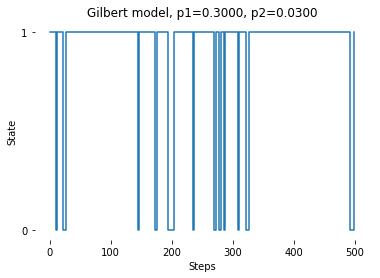

In [20]:
# simulate and plot    
p1, p2 = 0.3, 0.03
np.random.seed(2018)
states = gilbert_simulate(p1,p2, iters=500)
plot_gilbert(states, p1, p2)

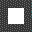

In [21]:
# show a low-fi simulation of this candle
candle_gif(states)

Your result will be random, but should look something like this (long periods of 1, with a few intermittent bursts of 0).
<img src="imgs/gilbert_simulate.png">


### Estimation
We  already saw how to estimate the distribution of a discrete random variable from observed data. 


In this case, where we have a dependency on the previous time step, we just need to compute the empirical distribution of the probability of sequential pairs of states, $P(S_i=s_i, S_{i+1}=s_{i+1})$, as in the letter bigrams in the Unit 8 lecture. From this, we can compute the conditional probabilities directly:

$$P(s_i | s_{i-1}) = \frac{P(s_i, s_{i-1})}{P(s_{i-1})} = \frac{P(s_i, s_{i-1})}{\sum_{s} P(s, s_{i-1})}$$

We can apply this to the sequence we generated, and test that we can recover the parameters that generated the observations.

Write a function to estimate `p1` and `p2` given a set of observed states. You should be able to verify that the results you get back are close to the original simulation parameters for any simulation you run.

You may find it helpful to print out intermediate joint or conditional matrices to help debug this code.


In [22]:
def estimate_gilbert_probabilities(states):
    """
        Parameters:
            states: list of states [0 or 1]
        Returns:
            p1, p2: estimated probabilities of the 
            Gilbert model that generated this sequence
    """
    # YOUR CODE HERE
    probs = np.zeros((2,2))
    for i in range(1, len(states)):
        probs[states[i],states[i-1]] += 1

    zero_total = probs[0,0] + probs[1,0]
    one_total = probs[0,1] + probs[1,1]
    probs[0,0] = probs[0,0] / zero_total
    probs[0,1] = 1 - probs[0,0]
    probs[1,1] = probs[1,1] / one_total
    probs[1,0] = 1 - probs[1,1]
    return probs[0,1], probs[1,0] 

In [23]:
np.random.seed(2018)
def report_results(p1, p2):
    print("""
    Estimated transition table
    ------------------------------
          0       1
    0   {p11:.2f}   {p1:.2f}
    1   {p2:.2f}   {p21:.2f}
""".format(p1=p1, p2=p2, p21=1-p2, p11=1-p1))
    
with tick.marks(8):
    for p1, p2 in [[0.2, 0.02], [0.5, 0.5], [0.9, 0.09],
                  [0.05, 0.05], [0.7, 0.1]]:    
        test_states = gilbert_simulate(p1, p2, iters=50000)    
        assert(len(test_states)==50000)            
        est_p1, est_p2 = estimate_gilbert_probabilities(test_states)            
        report_results(est_p1, est_p2)
        assert(np.abs(p1-est_p1)<0.02 and np.abs(p2-est_p2)<0.05)


    Estimated transition table
    ------------------------------
          0       1
    0   0.79   0.21
    1   0.02   0.98


    Estimated transition table
    ------------------------------
          0       1
    0   0.50   0.50
    1   0.50   0.50


    Estimated transition table
    ------------------------------
          0       1
    0   0.10   0.90
    1   0.09   0.91


    Estimated transition table
    ------------------------------
          0       1
    0   0.95   0.05
    1   0.05   0.95


    Estimated transition table
    ------------------------------
          0       1
    0   0.30   0.70
    1   0.10   0.90



We can verify that simulating with the probabilities observed from a simulation results in a quantitatively similar visual effect.

Text(0.5, 1.0, 'Re-simulation from estimated parameters 0.308, 0.026')

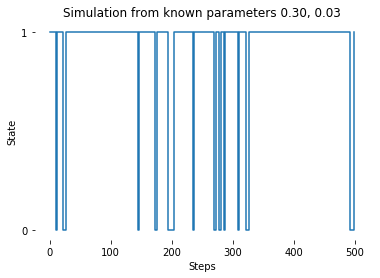

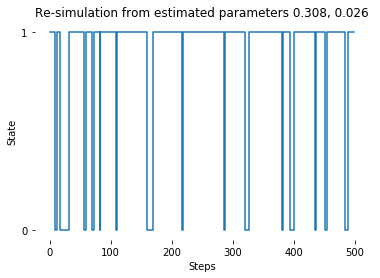

In [24]:
# simulate
p1, p2 = 0.3, 0.03
np.random.seed(2018)
states = gilbert_simulate(p1, p2, iters=500)
plot_gilbert(states, p1, p2)

plt.gca().set_title("Simulation from known parameters %.2f, %.2f" % (p1, p2))

est_p1, est_p2 = estimate_gilbert_probabilities(states)

est_states = gilbert_simulate(est_p1, est_p2, iters=500)
plot_gilbert(est_states, est_p1, est_p2)
plt.gca().set_title("Re-simulation from estimated parameters %.3f, %.3f" % (est_p1, est_p2))

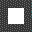

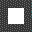

In [25]:
# check the candles look similar enough in simulation
candle_gif(states)
candle_gif(est_states)

### Likelihood
This **looks** qualitatively similar. We can precisely state that quantification using probability.

#### A bit of espionage
Imagine we want to conduct some industrial espionage ("market research") and work out which shops are being supplied with which brand of LED candle. There are candle modules from two companies, *RelaxiLight Inc.*, and *FlickerVision*. We have observations from lab studies of two examples of these candles.

We see a candle on the shelf in a hardware store. We take the candle home and measure the light emitted from it. Is it a *RelaxiLight* or a *FlickerVision*?

The question we want to ask is: given a sequence of observations, how likely is that the sequence was generated by one model or another? This is answerable via Bayes' Rule:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)},$$
where $A$ is the choice of candle model, and $B$ is the sequence of observations. This seems pretty abstract. We can break it down:

* $P(A)$ This is just the prior probability of the model. For example, if we know that 40% of all candles we might see are from RelaxiLight Inc., and 60% are from FlickerVision, we would have prior probability $P(A=\text{RelaxiLight})=0.4$.

* $P(B|A)$ is the **likelihood** of the observations. We can compute this from a sequence of observations $s_1, s_2, \dots$ as:
$$\prod_i P(s_i),$$ where $S_i$ is the random variable representing the light state. Our "state" is really the conditional probability of the current state given the previous
light state. Because we are dealing with a Markov process we can't compute the likelihood of a state without already knowing the previous state and the transition distribution:
$$\prod_i P(S_{i}=s_i|s_{i-1})$$

* $P(B)$ is hard to work out in general. We could sum over the possible states of A (here, it might just be RelaxiLight and FlickerVision), but this gets harder as the number of states of $A$ increases.

Luckily, this last point to do with $P(B)$ doesn't matter if all we want to do is to **compare** two possible models, since we just need the ratio 
$\frac{P(A_1|B)}{P(A_2|B)}$ to do this comparison. $P(B)$ cancels out in this expression and doesn't affect the results.

In practice, we need to use **log probabilities** to avoid floating-point underflow when multiplying many small probabilities together.

## Step 1. Load the data, estimate the parameters
* The data for observations from a known *RelaxiLight Inc.* candle  is in `data/relaxlight.txt`
* The data for observations from a known *FlickerVision* candle is in `data/flickervision.txt`
* The data for five unknown candles (the ones bought in the shops) is in `data/candle_<n>.txt`, for $n=1,2,3,4,5$

All of this data is just a single, long array of 0s and 1s (0 if the candle was off, 1 if it were on).

These are all standard RelaxiLight or FlickerVision candles; except for one, which is a slightly *defective* RelaxiLight or FlickerVision candle.

* Load known data into arrays `relaxilight` and `flickervision`. 
* Load the other five datasets into a 5xN matrix `unknown_candles` (all of the datasets are the same length)

These can be loaded directly with `np.loadtxt()`. Note that you **must** convert the array type to `int32` on loading for `estimate_gilbert_probabilities` to work

In [26]:
# YOUR CODE HERE
relaxilight = np.loadtxt('data/relaxilight.txt', dtype=np.int32)
flickervision = np.loadtxt('data/flickervision.txt', dtype=np.int32)
unknown = []
for i in range(1, 6):
    unknown.append(np.loadtxt('data/candle_{0}.txt'.format(i), dtype=np.int32))
unknown_candles = np.stack(unknown)

In [27]:
print(array_hash(relaxilight))
print(array_hash(flickervision))
print(array_hash(unknown_candles))
with tick.marks(5):
    assert(check_hash(relaxilight, ((5000,), 9858416.2025086209)))
    assert(check_hash(flickervision, ((5000,), 5990789.9841565806)))
    assert(check_hash(unknown_candles, ((5, 500), 2122668.1505949548)))
    assert(relaxilight.dtype==np.int32)
    assert(flickervision.dtype==np.int32)
    assert(unknown_candles.dtype==np.int32)


((5000,), 9858416.20250862)
((5000,), 5990789.984156581)
((5, 500), 2122668.150594955)


* Estimate the parameters for the **known** RelaxiLight Inc. and FlickerVision candles, using the function you defined above.
* Store the parameters in `relaxi_p1`, `relaxi_p2` and `flicker_p1` and `flicker_p2`

In [28]:
# YOUR CODE HERE
relaxi_p1, relaxi_p2 = estimate_gilbert_probabilities(relaxilight)
flicker_p1, flicker_p2 = estimate_gilbert_probabilities(flickervision)

In [29]:
ps = np.array([relaxi_p1, relaxi_p2, flicker_p1, flicker_p2])
print(ps)
with tick.marks(4):
    assert(np.sum(np.abs(ps - [ 0.09533898,  0.02219482,  0.23864959,  0.25392238]))<0.1)

[0.09533898 0.02219482 0.23864959 0.25392238]


### Step 2. Log-likelihood
Write a function that will compute the **log-likelihood** of a sequence given `p1` and `p2`. The easy way to approach this is to create a 2x2 conditional probability table for every possible pair of states, like the one in the first Gilbert example, and index into it as you iterate over the sequence of states.

Note that log-likelihoods will always be negative or zero.
    

In [32]:
def log_likelihood(seq, p1, p2):
    # YOUR CODE HERE
    probs = np.array([[1 - p1, p1], [p2, 1 - p2]])
    res = 0.0
    
    for i in range(1, len(seq)):
        res += np.log(probs[seq[i-1], seq[i]])
    return res

In [33]:

with tick.marks(6):
    assert(np.abs(log_likelihood([0,1,0,1], 0.5, 0.5) - -2.07944154168)<0.1)
    assert(np.abs(log_likelihood([0,1,1,1], 0.5, 0.2) - -1.13943428319)<0.1)
    assert(np.abs(log_likelihood([1,1,1,1], 0.5, 0.2) - -0.669430653943)<0.1)


### Step 3. Ratio test
25% of all candles on the market are RelaxiLight, and 75% of all candles are FlickerVision (flickery candles are cheap to produce!).

* Compute  the log probability ratio $$\log \left[ \frac{P(A_1|B)}{P(A_2|B)} \right]$$ that each of the five candles is to be a FlickerVision ($A_1$)over a RelaxiLight ($A_2$), storing the result in an array `candle_log_probs`. The log probability ratio includes both the likelihood and the prior.

* Create an array `is_flickervision` that has one entry for each unknown candle, 0 if the candle is most likely to be RelaxiLight, and 1 if the candle is most likely to be FlickerVision.



In [42]:
# YOUR CODE HERE
candle_log_probs = []
for n in range(5):
    candle_log_probs.append(log_likelihood(unknown_candles[n], estimate_gilbert_probabilities(flickervision)[0], estimate_gilbert_probabilities(flickervision)[1])+np.log(0.75) - log_likelihood(unknown_candles[n], estimate_gilbert_probabilities(relaxilight)[0], estimate_gilbert_probabilities(relaxilight)[1])-np.log(0.25))
candle_log_probs = np.array(candle_log_probs)    

In [46]:
# YOUR CODE HERE
is_flickervision = []
for n in range(5):
    is_flickervision.append(np.where(candle_log_probs[n] < 0.75, 0, 1))
is_flickervision = np.array(is_flickervision)    

In [47]:
print(candle_log_probs)
with tick.marks(5):
    assert(np.sum(np.abs(candle_log_probs-[-91,119,-74,-97,140]))<5.0)

[-91.71633843 119.87678557 -74.07528499 -97.79321901 140.20061013]


In [48]:
print(is_flickervision)
print(array_hash(is_flickervision))
with tick.marks(4):
    assert(check_hash(is_flickervision, ((5,), 8.8898979485566354)))

[0 1 0 0 1]
((5,), 8.889897948556635)



* Which candle is most likely to be the defective one?
[no marks for this; skip it if you can't work out how to answer this question!]
    

In [ ]:
# YOUR CODE HERE

-----

# Submission instructions

### Checking your work
## Mark summary
You should check the marks you've got before submitting. To do this, 
* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and matriculation number at the top.
* SAVE THE NOTEBOOK, 
* Go to `Cell/Restart and Run All` in the menu.
* Check the output of the cell here.

Note that this is an estimated mark, and if you don't do the above procedure *carefully* you may get nonsense estimates.


In [ ]:
tick.summarise_marks()

### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `lab_<xxx>.ipynb`.


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Any form of plagiarism will be subject to the Plagiarism Policy. The penalties are severe.